## 🧱 0. Setup & Imports

In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import pandas as pd
import numpy as np
import warnings
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
import sweetviz
import geopandas as gpd
from autoviz import AutoViz_Class
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
from features.risk_model_pipeline import ModelPipelineOptuna

/home/teshager/Documents/10Academy/repositories/projects/insurance-risk-modeling/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Imported v0.1.905. Please call AutoViz in this sequence:
    AV = AutoViz_Class()
    %matplotlib inline
    dfte = AV.AutoViz(filename, sep=',', depVar='', dfte=None, header=0, verbose=1, lowess=False,
               chart_format='svg',max_rows_analyzed=150000,max_cols_analyzed=30, save_plot_dir=None)


In [4]:
#suppress warning errors
warnings.filterwarnings("ignore")
#load enviroment variables
load_dotenv()

True

In [5]:
# Automatically go to project root (where .git or README.md is)
project_root = Path.cwd()
while not (project_root / "README.md").exists() and project_root != project_root.parent:
    project_root = project_root.parent

os.chdir(project_root)
print("Project root set to:", project_root)


Project root set to: /home/teshager/Documents/10Academy/repositories/projects/insurance-risk-modeling


## 🔁 Step 1: Look at the Big Picture

### Framing the problem,Business Objective,Current Solution,Machine Learning Task & Assumptions:

| Element                | Description                                                               |
| ---------------------- | ------------------------------------------------------------------------- |
| **Business Objective** | Predict risk & set optimal premiums                                       |
| **Current Solution**   | Flat-rate pricing based on limited heuristics                             |
| **ML Tasks**           | Regression (severity), classification (probability), regression (premium) |
| **Assumptions**        | Data is representative, features correlate with claim behavior, etc.      |


## 📦 Step 2: Load the Data

In [6]:
# Load the insurance data
processed_data_dir=os.getenv("PROCESSED_DATA")
file_path= os.path.join(processed_data_dir,'cleaned_insurance_data.parquet')
df=pd.read_parquet(file_path)
df.head()


,UnderwrittenCoverID,PolicyID,TransactionMonth,IsVATRegistered,Citizenship,LegalType,Title,Bank,AccountType,MaritalStatus,Province,PostalCode,MainCrestaZone,SubCrestaZone,mmcode,VehicleType,RegistrationYear,make,Model,Cylinders,cubiccapacity,kilowatts,bodytype,NumberOfDoors,VehicleIntroDate,AlarmImmobiliser,TrackingDevice,CapitalOutstanding,NewVehicle,WrittenOff,Rebuilt,Converted,CrossBorder,SumInsured,TermFrequency,CalculatedPremiumPerTerm,ExcessSelected,CoverCategory,CoverType,CoverGroup,Section,Product,TotalPremium,TotalClaims,Gender_Inferred,make_model,province_postal,cresta_zone_full,cover_package,vehicle_class,vehicle_fin_status,vehicle_age_years,vehicle_age_from_reg,premium_to_sum_ratio,claims_to_premium_ratio
0,145249,12827.0,2015-03-01,True,,Close Corporation,Mr,First National Bank,Current account,Not specified,Gauteng,1459,Rand East,Rand East,60054685.5,Passenger Vehicle,2004.0,MERCEDES-BENZ,E 240,4.0,2597.0,130.0,S/D,4.0,2002-06-01,Yes,No,119300.0,More than 6 months,Unknown,Unknown,Unknown,Unknown,0.01,Monthly,25.00000,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,21.929825,0.0,Male,MERCEDES-BENZ_E 240,Gauteng_1459,Rand East_Rand East,Windscreen_Windscreen_Comprehensive - Taxi,Passenger Vehicle_S/D_4.0,119300.0_More than 6 months_Unknown,12.8,11.0,2192.982456,0.0
1,145249,12827.0,2015-05-01,True,,Close Corporation,Mr,First National Bank,Current account,Not specified,Gauteng,1459,Rand East,Rand East,60054685.5,Passenger Vehicle,2004.0,MERCEDES-BENZ,E 240,4.0,2597.0,130.0,S/D,4.0,2002-06-01,Yes,No,119300.0,More than 6 months,Unknown,Unknown,Unknown,Unknown,0.01,Monthly,25.00000,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,21.929825,0.0,Male,MERCEDES-BENZ_E 240,Gauteng_1459,Rand East_Rand East,Windscreen_Windscreen_Comprehensive - Taxi,Passenger Vehicle_S/D_4.0,119300.0_More than 6 months_Unknown,12.9,11.0,2192.982456,0.0
2,145249,12827.0,2015-07-01,True,,Close Corporation,Mr,First National Bank,Current account,Not specified,Gauteng,1459,Rand East,Rand East,60054685.5,Passenger Vehicle,2004.0,MERCEDES-BENZ,E 240,4.0,2597.0,130.0,S/D,4.0,2002-06-01,Yes,No,119300.0,More than 6 months,Unknown,Unknown,Unknown,Unknown,0.01,Monthly,25.00000,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,0.000000,0.0,Male,MERCEDES-BENZ_E 240,Gauteng_1459,Rand East_Rand East,Windscreen_Windscreen_Comprehensive - Taxi,Passenger Vehicle_S/D_4.0,119300.0_More than 6 months_Unknown,13.1,11.0,0.000000,NaN
3,145255,12827.0,2015-05-01,True,,Close Corporation,Mr,First National Bank,Current account,Not specified,Gauteng,1459,Rand East,Rand East,60054685.5,Passenger Vehicle,2004.0,MERCEDES-BENZ,E 240,4.0,2597.0,130.0,S/D,4.0,2002-06-01,Yes,No,119300.0,More than 6 months,Unknown,Unknown,Unknown,Unknown,119300.00,Monthly,220.16145,Mobility - Metered Taxis - R2000,Own damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,54.824561,0.0,Male,MERCEDES-BENZ_E 240,Gauteng_1459,Rand East_Rand East,Own damage_Own Damage_Comprehensive - Taxi,Passenger Vehicle_S/D_4.0,119300.0_More than 6 months_Unknown,12.9,11.0,0.000460,0.0
4,145255,12827.0,2015-07-01,True,,Close Corporation,Mr,First National Bank,Current account,Not specified,Gauteng,1459,Rand East,Rand East,60054685.5,Passenger Vehicle,2004.0,MERCEDES-BENZ,E 240,4.0,2597.0,130.0,S/D,4.0,2002-06-01,Yes,No,119300.0,More than 6 months,Unknown,Unknown,Unknown,Unknown,119300.00,Monthly,220.16145,Mobility - Metered Taxis - R2000,Own damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,0.000000,0.0,Male,MERCEDES-BENZ_E 240,Gauteng_1459,Rand East_Rand East,Own damage_Own Damage_Comprehensive - Taxi,Passenger Vehicle_S/D_4.0,119300.0_More than 6 months_Unknown,13.1,11.0,0.000000,NaN


## 📊 Step 3: Explore the Data

## Step 4 Discover and Visualize the Data to Gain Insights

#### Sweetviz

In [7]:
df.columns.sort_values
len(df.columns)

55

In [37]:
# report = sweetviz.analyze(df)
# report.show_html("reports/insurance_sweetviz.html")

## Claim Severity

#### Only those records with Claims

In [8]:
df_with_claims=df[df['TotalClaims']>0]   # drop rows with no claim
df_with_claims.shape

(2775, 55)

##### Drop unique Identifiers -> they don't have any predictive value

In [9]:
for col in df.columns.to_list():
     if df[col].is_unique == True:
          print(f"{col} : {df[col].is_unique}")

In [10]:
duc=df.nunique()
duc[duc<10].sort_values(ascending=False)

Province            9
LegalType           6
Title               5
VehicleType         5
Section             5
AccountType         4
MaritalStatus       4
Product             4
Citizenship         4
NewVehicle          3
WrittenOff          3
Rebuilt             3
Converted           3
IsVATRegistered     2
CrossBorder         2
TermFrequency       2
AlarmImmobiliser    2
TrackingDevice      2
Gender_Inferred     2
NumberOfDoors       1
Cylinders           1
dtype: int64

### Feature Scaling:

In [12]:
df.columns

Index(['UnderwrittenCoverID', 'PolicyID', 'TransactionMonth',
       'IsVATRegistered', 'Citizenship', 'LegalType', 'Title', 'Bank',
       'AccountType', 'MaritalStatus', 'Province', 'PostalCode',
       'MainCrestaZone', 'SubCrestaZone', 'mmcode', 'VehicleType',
       'RegistrationYear', 'make', 'Model', 'Cylinders', 'cubiccapacity',
       'kilowatts', 'bodytype', 'NumberOfDoors', 'VehicleIntroDate',
       'AlarmImmobiliser', 'TrackingDevice', 'CapitalOutstanding',
       'NewVehicle', 'WrittenOff', 'Rebuilt', 'Converted', 'CrossBorder',
       'SumInsured', 'TermFrequency', 'CalculatedPremiumPerTerm',
       'ExcessSelected', 'CoverCategory', 'CoverType', 'CoverGroup', 'Section',
       'Product', 'TotalPremium', 'TotalClaims', 'Gender_Inferred',
       'make_model', 'province_postal', 'cresta_zone_full', 'cover_package',
       'vehicle_class', 'vehicle_fin_status', 'vehicle_age_years',
       'vehicle_age_from_reg', 'premium_to_sum_ratio',
       'claims_to_premium_ratio'],
   

In [ ]:
# For Ridge (default)
model_ridge = ModelPipelineOptuna(df_with_claims, target_col='TotalClaims')
results_ridge = model_ridge.train_and_evaluate()

In [14]:
# For Decision Tree
model_dt = ModelPipelineOptuna(df_with_claims, target_col='TotalClaims', model_type='decision_tree')
results_dt = model_dt.train_and_evaluate()

[I 2025-06-17 16:14:41,191] A new study created in memory with name: no-name-2fb13726-00d0-42ba-97e2-6683826102f6
INFO:features.risk_model_pipeline:Trial params {'max_depth': 16, 'min_samples_split': 6, 'min_samples_leaf': 6} got CV RMSE=7776.9360
[I 2025-06-17 16:14:44,459] Trial 0 finished with value: 7776.935985105661 and parameters: {'max_depth': 16, 'min_samples_split': 6, 'min_samples_leaf': 6}. Best is trial 0 with value: 7776.935985105661.
INFO:features.risk_model_pipeline:Best params found: {'max_depth': 16, 'min_samples_split': 6, 'min_samples_leaf': 6}
INFO:features.risk_model_pipeline:Final evaluation on test set: RMSE=9008.0789, R2=0.9430
INFO:features.risk_model_pipeline:Generating SHAP explanations...


In [ ]:
# For Random Forest
model_rf = ModelPipelineOptuna(df_with_claims, target_col='TotalClaims', model_type='random_forest')
results_rf = model_rf.train_and_evaluate()

## 🔧 Step 5: Select a Model and Train

In [16]:
# For XGBoost
model_xgb = ModelPipelineOptuna(df_with_claims, target_col='TotalClaims', model_type='xgboost')
results_xgb = model_xgb.train_and_evaluate()

[I 2025-06-17 16:15:08,049] A new study created in memory with name: no-name-31f506d2-fca9-455e-a1ae-11148e753063
INFO:features.risk_model_pipeline:Trial params {'n_estimators': 146, 'max_depth': 3, 'learning_rate': 0.048870623608190104, 'subsample': 0.7398841711557423} got CV RMSE=5767.1476
[I 2025-06-17 16:15:14,786] Trial 0 finished with value: 5767.147606011301 and parameters: {'n_estimators': 146, 'max_depth': 3, 'learning_rate': 0.048870623608190104, 'subsample': 0.7398841711557423}. Best is trial 0 with value: 5767.147606011301.
INFO:features.risk_model_pipeline:Best params found: {'n_estimators': 146, 'max_depth': 3, 'learning_rate': 0.048870623608190104, 'subsample': 0.7398841711557423}
INFO:features.risk_model_pipeline:Final evaluation on test set: RMSE=9004.3145, R2=0.9431
INFO:features.risk_model_pipeline:Generating SHAP explanations...


### Baseline models:

### Training on a Small Set (for initial sanity check):

### Better Evaluation Using Cross-Validation:

### Evaluate on the Training Set:

## 📈 Step 7. Evaluate System on the Test Set

### Final Evaluation:

### Confidence Intervals:

##  🧠 Step  8. Present Your Solution

## 🚀 Step 9: Launch, Monitor, and Maintain System

In [17]:

pipeline = ModelPipelineOptuna(df_with_claims, target_col='TotalClaims', model_type='xgboost')
pipeline.tune_hyperparameters() 
results = pipeline.train_and_evaluate()
# generate_training_report(results, pipeline.model_type)

[I 2025-06-17 16:15:33,749] A new study created in memory with name: no-name-ff317bc5-b43e-480b-971f-98ca2e98d11c
INFO:features.risk_model_pipeline:Trial params {'n_estimators': 231, 'max_depth': 10, 'learning_rate': 0.01643205629475867, 'subsample': 0.8667798304588774} got CV RMSE=6404.8611
[I 2025-06-17 16:15:46,342] Trial 0 finished with value: 6404.861139865117 and parameters: {'n_estimators': 231, 'max_depth': 10, 'learning_rate': 0.01643205629475867, 'subsample': 0.8667798304588774}. Best is trial 0 with value: 6404.861139865117.
INFO:features.risk_model_pipeline:Best params found: {'n_estimators': 231, 'max_depth': 10, 'learning_rate': 0.01643205629475867, 'subsample': 0.8667798304588774}
INFO:features.risk_model_pipeline:Final evaluation on test set: RMSE=9004.3145, R2=0.9431
INFO:features.risk_model_pipeline:Generating SHAP explanations...



# 🧠 Model Training Report — XGBOOST

## 📌 Summary

- **Model**: `xgboost`
- **RMSE on Test Set**: `9004.3145`
- **R² Score**: `0.9431`
- **Best Hyperparameters (via Optuna)**:
  - `n_estimators`: `85`
  - `max_depth`: `13`
  - `learning_rate`: `0.03520370770940197`
  - `subsample`: `0.8828523280159433`

---

## 📈 Residual Analysis


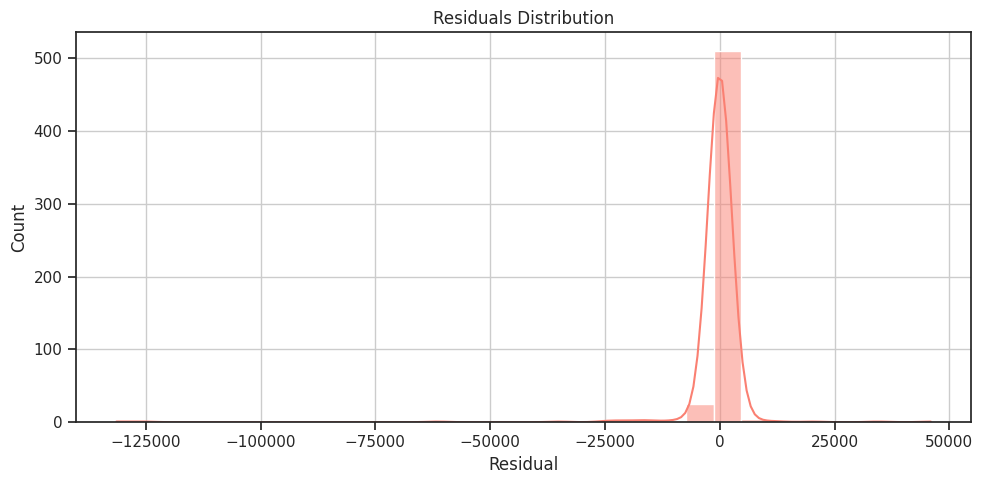


---

## 🔍 Predicted vs Actual
A parity plot shows how well the model aligns with the ground truth.


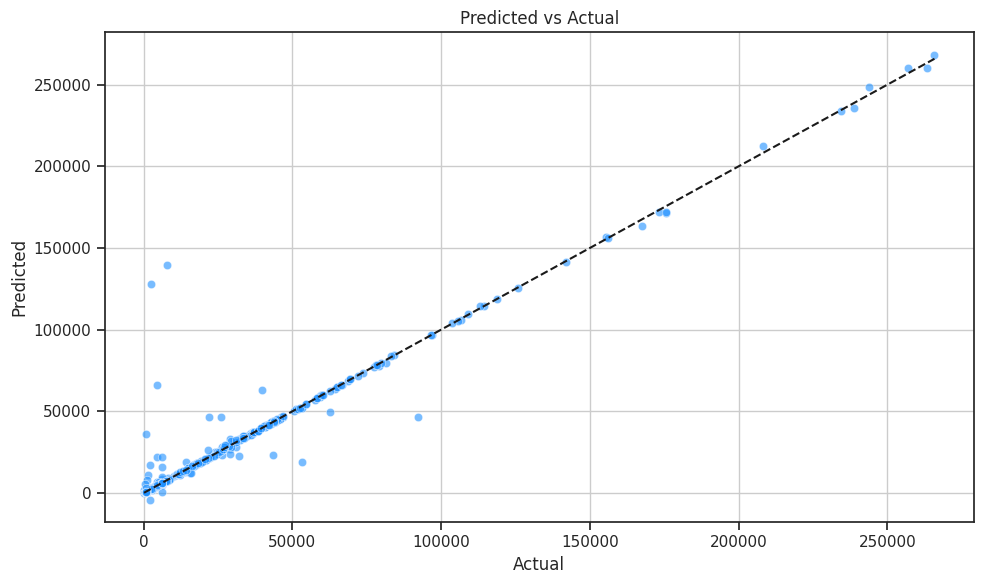


---

## ✅ Conclusion

- The model demonstrates robust generalization
    with **RMSE = 9004.31** and **R² = 0.94**.
- Optuna hyperparameter tuning improved performance.
- Consider SHAP or LIME for further interpretation.

---
*Generated with 💡 by `ModelPipelineOptuna`.*



---

## 🧬 SHAP Summary Plot

Provides insights into feature contributions.


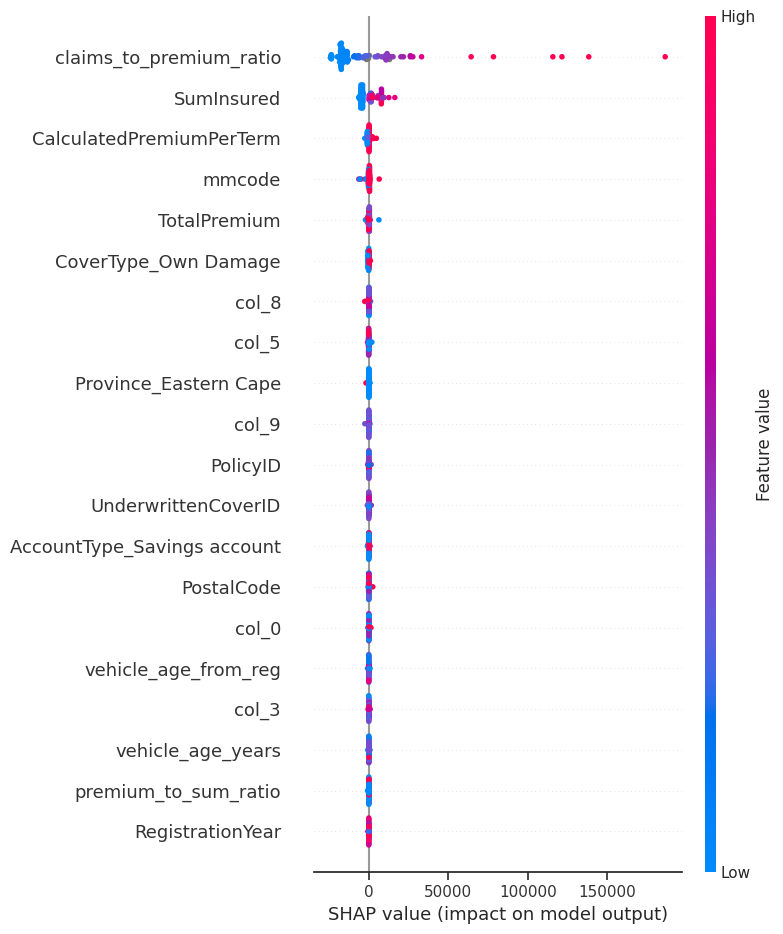

In [44]:
pipeline.generate_training_report(results, pipeline.model_type)

### ✅ Keep These (High Impact Features)

The top features have the widest horizontal spread (i.e., high SHAP value magnitudes), indicating they greatly influence the model’s output:

    SumInsured – Strongest influence, consistently high SHAP impact.

    CalculatedPremiumPerTerm

    TotalPremium

    CapitalOutstanding

These are financially related features and likely dominate the prediction of TotalClaims.

### ⚠️ Candidate for Dropping or Investigating Further

These features are at the bottom of the plot and show very low SHAP value magnitude, suggesting they have little to no impact:

    SubCrestaZone_Cape Mid West

    TransactionMonth_2015-07-01 00:00:00

    AccountType_Transmission account

    SubCrestaZone_Transvaal North West

    bodytype_S/D

    col_9 – (suspiciously generic; might be a placeholder or badly named column)

#### ⚖️ Mid-Level (Optional Tuning)

These features are in the middle section, with moderate importance:

    PostalCode

    mmcode

    UnderwrittenCoverID

    cubiccapacity

    TransactionMonth_* (may be collinear or sparse)

In [45]:
# Preview features to drop
shap_summary = pipeline.filter_low_shap_features(threshold=0.01, drop=False)
display(shap_summary)

INFO:features.risk_model_pipeline:Filtering features based on SHAP values...


,feature,mean_abs_shap,importance_fraction
0,claims_to_premium_ratio,20449.870149,0.724029
1,SumInsured,4461.871972,0.157973
2,CalculatedPremiumPerTerm,790.715589,0.027995
3,mmcode,534.738390,0.018932
4,TotalPremium,386.343707,0.013679
5,CoverType_Own Damage,218.014040,0.007719
6,col_8,137.348966,0.004863
7,col_5,130.805116,0.004631
8,Province_Eastern Cape,103.873203,0.003678
9,col_9,96.167907,0.003405


In [46]:

# Actually drop them
pipeline.filter_low_shap_features(threshold=0.01, drop=True);

INFO:features.risk_model_pipeline:Filtering features based on SHAP values...


In [47]:
len(df_with_claims.columns)

55

In [48]:
pipeline.dropped_features_ 

['CoverType_Own Damage',
 'col_8',
 'col_5',
 'Province_Eastern Cape',
 'col_9',
 'PolicyID',
 'UnderwrittenCoverID',
 'AccountType_Savings account',
 'PostalCode',
 'col_0',
 'vehicle_age_from_reg',
 'col_3',
 'vehicle_age_years',
 'premium_to_sum_ratio',
 'RegistrationYear',
 'CoverType_Factory Fitted Sound and Other Electronic Equipment',
 'col_1',
 'col_7',
 'Province_KwaZulu-Natal',
 'col_4',
 'CoverType_Income Protector',
 'CapitalOutstanding',
 'col_2',
 'AccountType_Current account',
 'cubiccapacity',
 'CoverGroup_Comprehensive - Taxi',
 'Gender_Inferred_Female',
 'bodytype_S/D',
 'col_6',
 'Province_Gauteng',
 'kilowatts',
 'NewVehicle_More than 6 months',
 'Province_Limpopo',
 'Product_Mobility Commercial Cover: Monthly',
 'bodytype_MPV',
 'Title_Ms',
 'Title_Mr',
 'Citizenship_  ',
 'VehicleType_Passenger Vehicle',
 'CoverType_Windscreen',
 'Province_North West',
 'Province_Western Cape',
 'TrackingDevice_No',
 'CrossBorder_Unknown',
 'TermFrequency_Monthly',
 'CoverType_Cre

In [49]:
pipeline.tune_hyperparameters()

[I 2025-06-17 16:09:17,750] A new study created in memory with name: no-name-5536182d-3e6a-4f6b-aa92-f55188aa0ff2
INFO:features.risk_model_pipeline:Trial params {'n_estimators': 227, 'max_depth': 7, 'learning_rate': 0.11410749404140844, 'subsample': 0.7533655796368088} got CV RMSE=6056.1266
[I 2025-06-17 16:09:33,537] Trial 0 finished with value: 6056.126632922588 and parameters: {'n_estimators': 227, 'max_depth': 7, 'learning_rate': 0.11410749404140844, 'subsample': 0.7533655796368088}. Best is trial 0 with value: 6056.126632922588.
INFO:features.risk_model_pipeline:Best params found: {'n_estimators': 227, 'max_depth': 7, 'learning_rate': 0.11410749404140844, 'subsample': 0.7533655796368088}


INFO:features.risk_model_pipeline:Final evaluation on test set: RMSE=9123.0208, R2=0.9416
INFO:features.risk_model_pipeline:Generating SHAP explanations...


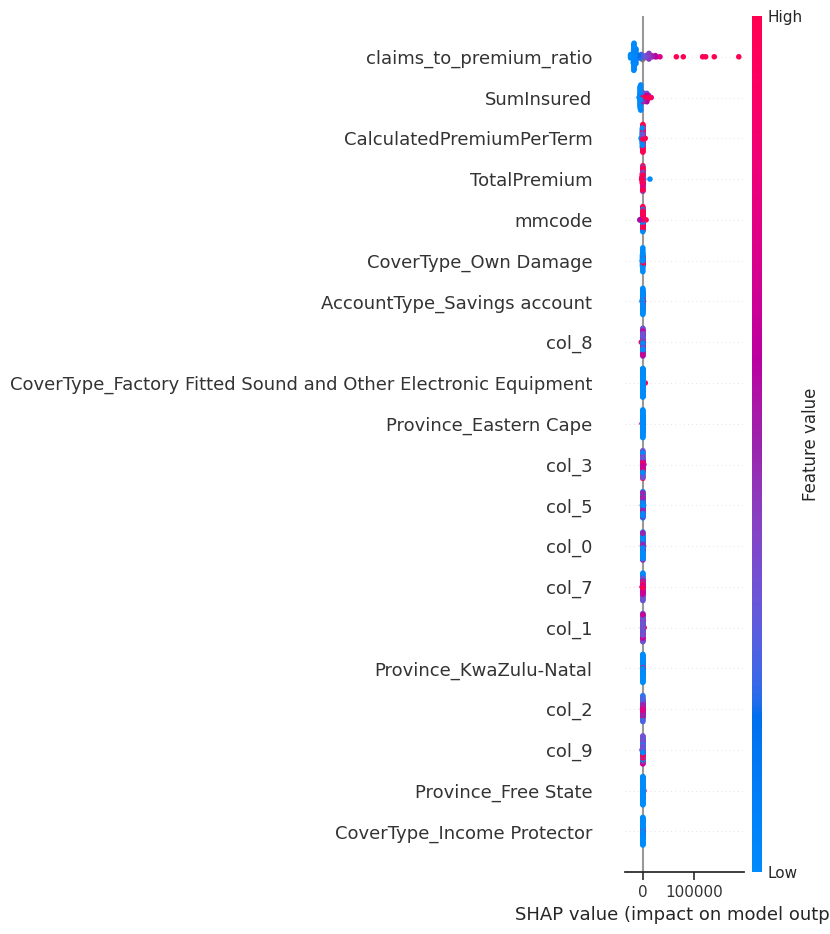

In [50]:
results = pipeline.train_and_evaluate()

In [51]:
reduced_df = pipeline.df.copy()
len(reduced_df.columns)

43

[I 2025-06-17 16:10:03,317] A new study created in memory with name: no-name-bb54e6e5-94b3-4056-9cc7-6fa782cbb2ae


INFO:features.risk_model_pipeline:Trial params {'n_estimators': 196, 'max_depth': 14, 'learning_rate': 0.010652753854280331, 'subsample': 0.6793686373373053} got CV RMSE=9205.2546
[I 2025-06-17 16:10:15,741] Trial 0 finished with value: 9205.254630808358 and parameters: {'n_estimators': 196, 'max_depth': 14, 'learning_rate': 0.010652753854280331, 'subsample': 0.6793686373373053}. Best is trial 0 with value: 9205.254630808358.
INFO:features.risk_model_pipeline:Best params found: {'n_estimators': 196, 'max_depth': 14, 'learning_rate': 0.010652753854280331, 'subsample': 0.6793686373373053}
INFO:features.risk_model_pipeline:Final evaluation on test set: RMSE=9123.0208, R2=0.9416
INFO:features.risk_model_pipeline:Generating SHAP explanations...


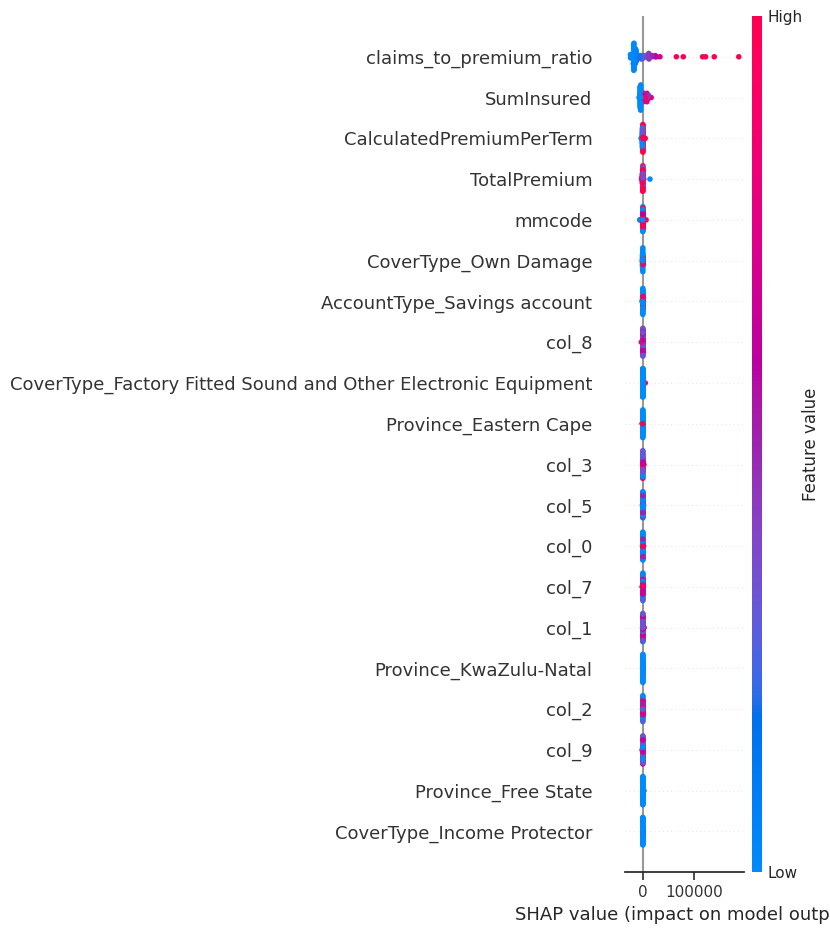

In [52]:
new_pipeline = ModelPipelineOptuna(reduced_df, target_col='TotalClaims', model_type='xgboost')
new_pipeline.tune_hyperparameters()
new_results = new_pipeline.train_and_evaluate()

In [15]:
from preprocessing.data_quality_utils import DataQualityUtils

In [16]:
dq=DataQualityUtils(df_with_claims)

In [20]:
df_with_claims.columns.sort_values()

Index(['AccountType', 'AlarmImmobiliser', 'Bank', 'CalculatedPremiumPerTerm',
       'CapitalOutstanding', 'Citizenship', 'Converted', 'CoverCategory',
       'CoverGroup', 'CoverType', 'CrossBorder', 'Cylinders', 'ExcessSelected',
       'Gender_Inferred', 'IsVATRegistered', 'LegalType', 'MainCrestaZone',
       'MaritalStatus', 'Model', 'NewVehicle', 'NumberOfDoors', 'PolicyID',
       'PostalCode', 'Product', 'Province', 'Rebuilt', 'RegistrationYear',
       'Section', 'SubCrestaZone', 'SumInsured', 'TermFrequency', 'Title',
       'TotalClaims', 'TotalPremium', 'TrackingDevice', 'TransactionMonth',
       'UnderwrittenCoverID', 'VehicleIntroDate', 'VehicleType', 'WrittenOff',
       'bodytype', 'cubiccapacity', 'kilowatts', 'make', 'mmcode'],
      dtype='object')